# Machine Learning - Predict Good Quality White Vinho Verde

In this notebook a machine learning model to predict the quality of white vinho verde wines is implemented and evaluated. 

The goal is to predict if a wine is high quality or not

# Import Packages and Functions

In [1286]:
import pandas as pd
# import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np


from xgboost import XGBClassifier 

import sklearn
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
# from sklearn.impute import SimpleImputer
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    precision_recall_fscore_support,
    classification_report, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score
)
from sklearn.inspection import permutation_importance

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

import shap

# TODO checkout this pipeline library 
# from neuraxle.pipeline import Pipeline

In [1287]:
%run ../src/constants.py

# Import and Pre-clean Data

In [1288]:
# import white wine
wine = pd.read_parquet('../data/processed/wine_w.parquet')

In [1289]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3961 entries, 0 to 4897
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   ph                                   3961 non-null   float64 
 1   fixed_acidity                        3961 non-null   float64 
 2   volatile_acidity                     3961 non-null   float64 
 3   citric_acid                          3961 non-null   float64 
 4   chlorides                            3961 non-null   float64 
 5   total_sulfur_dioxide                 3961 non-null   float64 
 6   free_sulfur_dioxide                  3961 non-null   float64 
 7   sulphates                            3961 non-null   float64 
 8   residual_sugar                       3961 non-null   float64 
 9   density                              3961 non-null   float64 
 10  alcohol                              3961 non-null   float64 
 11  quality               

## Config

In [1290]:
remove_outliers = True
DO_SHAP_EXPLAINER = True
DO_CROSS_VAL = True

features_removed = [
    'color',
    # 'fixed_acidity', 'volatile_acidity', 'citric_acid',
    'total_acidity',
    # 'total_sulfur_dioxide', 
    # 'free_sulfur_dioxide',
    # 'sulphates',
    # 'residual_sugar',
    # 'ph',
    # 'density',
    'acidity_ratio',
    'sulfur_dioxide_ratio',
    'total_sulfur_dioxide_above_eu_limit', 
    'volatile_acid_above_eu_limit'
    ]

target, target_alt = 'quality_label', 'quality'
# target, target_alt = target_alt, target
features_removed.append(target_alt)

## Remove outliers

Remove low quality outlier wines!

In [1291]:
MIN_Q_RATING = 7

if remove_outliers:
    outlier_mask = ((wine.input_outlier_count>=1) | wine.input_outliers_if) & (wine.quality<=MIN_Q_RATING)
    # outlier_mask = ((wine.input_outlier_count>=1)) & (wine.quality<=MIN_Q_RATING)
    wine = wine[~outlier_mask]
wine = wine.drop(columns=['input_outlier_count', 'input_outliers_if'])
wine.shape

(3362, 19)

In [1292]:
if outlier_mask is not None:
    print(sum(outlier_mask))

599


## Remove Features

In [1293]:
wine = wine.drop(columns=features_removed)

features = [input for input in wine.columns if (input not in features_removed) and (input != target) and (input != target)]
print('selected features are:')
features

selected features are:


['ph',
 'fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'chlorides',
 'total_sulfur_dioxide',
 'free_sulfur_dioxide',
 'sulphates',
 'residual_sugar',
 'density',
 'alcohol']

## Analyse Input Data

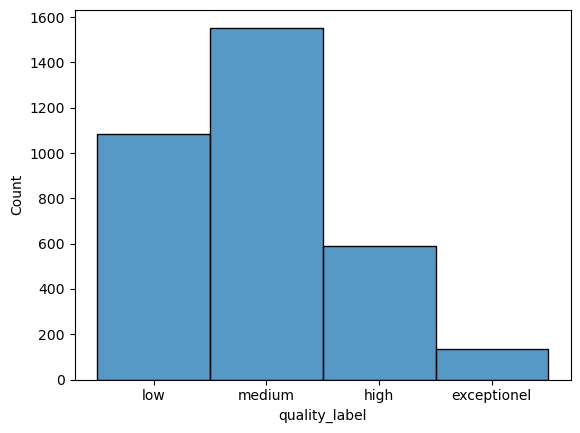

In [1294]:
if 'quality_label' in wine.columns:
    sns.histplot(wine, x='quality_label', discrete=True);
else:
    sns.histplot(wine, x='quality', discrete=True);

# Transform Target

In [1295]:
# encode quality label
if 'quality_label' in wine.columns:
    # TODO is there another way to ensure order? seems kind of sloppy
    categories_in_order = list(wine.quality_label.value_counts().sort_index().index) # such that number of labels can be changed 
    oe = OrdinalEncoder(categories=[categories_in_order]) # NOTE give the order in here; has to be an array of n features 
    wine['quality_label'] = oe.fit_transform(pd.DataFrame(wine['quality_label'])) # NOTE conversion to dataframe needed here, because that bastard requires a (n_samples, n_features) shape
    qlabels = sorted(wine.quality_label.unique()) #[0.0, 2.0, 3.0]

# Split Data Set

In [1296]:
# Split the data into training and testing sets
# TODO move configuration to config file?
TEST_SIZE = 0.20
RANDOM_STATE = 42

X = wine[features]
if 'quality_label' in wine.columns:
    y = wine.quality_label
else:
    y = wine.quality

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

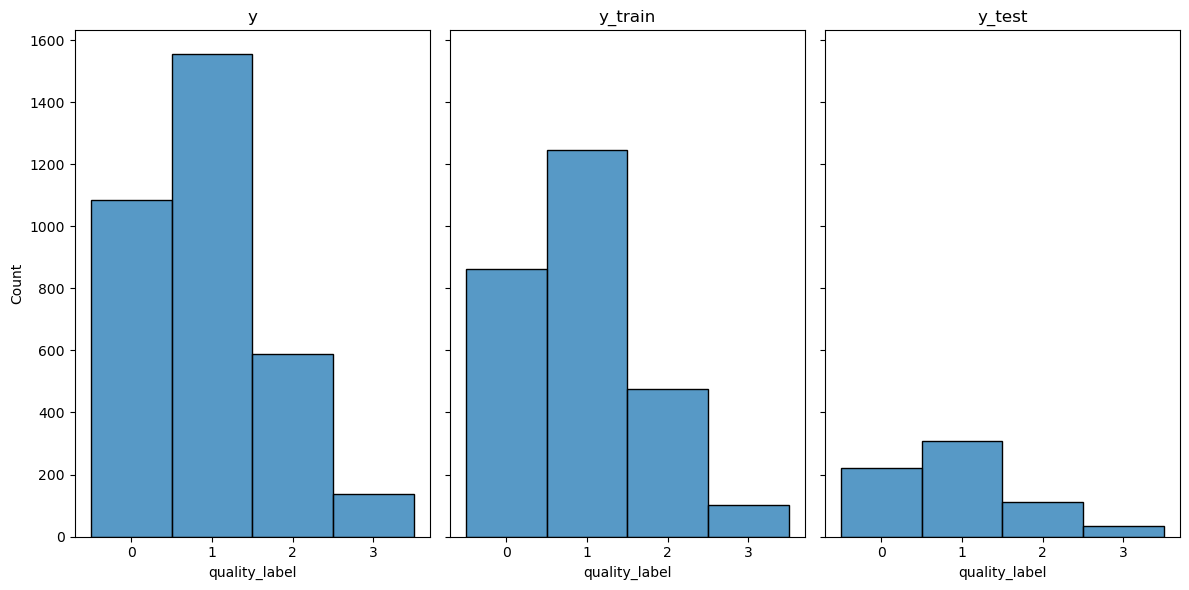

In [1297]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)

sns.histplot(y, discrete=True, ax=ax[0])
sns.histplot(y_train, discrete=True, ax=ax[1])
sns.histplot(y_test, discrete=True, ax=ax[2])

ax[0].set_title('y')
ax[1].set_title('y_train')
ax[2].set_title('y_test')

plt.tight_layout()

In [1298]:
quality_label_vcounts = y_train.value_counts()
quality_label_vcounts

quality_label
1.0    1247
0.0     864
2.0     475
3.0     103
Name: count, dtype: int64

# Machine Learning

In [1299]:
# configure sampling
# TODO How should I distribute the classes?

def calc_undersampling_startegy(y):
    '''
    calculate undersampling strategy for wine quality label
      - undersample majority class to 80%
      - undersample other classes to minority class
      - keep minority class
    '''
    UNDERSAMPLING_FAC_MAJ_CLASS=0.8
    # quality_label_vcounts = y.value_counts()
    unique, counts = np.unique(y, return_counts=True)
    quality_label_vcounts = dict(zip(unique,counts))
    return {
        0: quality_label_vcounts[2], #min(quality_label_vcounts[0], quality_label_vcounts[2]),
        1: int(np.floor(UNDERSAMPLING_FAC_MAJ_CLASS*quality_label_vcounts[1])),
        2: quality_label_vcounts[2],
        3: quality_label_vcounts[3]
        }

undersampling_strategy = calc_undersampling_startegy
# undersampling_strategy = 'auto'
oversampling_strategy = 'auto'

In [1300]:
# Build Pipeline
pipe = Pipeline(steps=[
        ("scaler", RobustScaler()),
        # ("scaler", MinMaxScaler()),
        # ("scaler", StandardScaler()),
        # ('pca', PCA(n_components=7)),
        ('undersampling', RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=RANDOM_STATE)),
        ('oversampling', SMOTE(sampling_strategy=oversampling_strategy, random_state=RANDOM_STATE)),
        # ('combinedsampling', SMOTEENN(sampling_strategy=oversampling_strategy, random_state=RANDOM_STATE)),
        ("classifier", RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1, oob_score=True)),
        # ("classifier", SVC())
        ])
pipe

Pipeline(steps=[('scaler', RobustScaler()),
                ('undersampling',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy=<function calc_undersampling_startegy at 0x000001A0E625BE20>)),
                ('oversampling', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, oob_score=True,
                                        random_state=42))])

In [ ]:
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
# from skopt import BayesSearchCV

# Define the parameter grid for RandomForestClassifier
param_grid_rf = {
    'classifier__n_estimators': [100, 1000], # 1000
    'classifier__max_depth': [None], # None
    'classifier__min_samples_split': [2, 5, 10], # 2
    'classifier__min_samples_leaf': [1, 3, 5], # 1
    'classifier__criterion': ['entropy']
    # 'classifier__random_state': [RANDOM_STATE]
}

# # Create a custom scoring function for the F1-score of the target class
# def f1_score_class_high(y_true, y_pred):
#     f1_scores = f1_score(y_true, y_pred, average=None)
#     # Assuming your target class has index 1
#     if len(f1_scores) > 2:
#         score = f1_scores[2]
#         if len(f1_scores) > 3:
#             score += f1_scores[3]
#             score /= 2
#     else:
#         score = 0.0  # Handle cases where the class might not be present in a fold
#     return score

# Create a scorer object from your custom function
# scorer = make_scorer(f1_score_class_high)
# scorer = make_scorer(accuracy_score)
scorer = make_scorer(lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'))

cv = StratifiedKFold(n_splits=5)

# grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring=scorer)
grid_search_rf = GridSearchCV(pipe, param_grid_rf, cv=cv, scoring=scorer)

# Fit GridSearchCV to the training data
grid_search_rf.fit(X_train, y_train)

# Get the best parameters and the best score
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print("Best parameters for RandomForestClassifier:", best_params_rf)
print("Best score:", best_score_rf)

Best parameters for RandomForestClassifier: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 1000}
Best score: 0.5539756965945231


In [1309]:
pipe[-1].set_params(**{key.replace('classifier__',''): val for key,val in best_params_rf.items()})
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# Evaluate

## Baseline

In [1310]:
# fraction of high quality labeled wines
probs_quality_label = wine.quality_label.value_counts() / wine.quality_label.sum()
prob_high_quality = probs_quality_label[2]+probs_quality_label[3]
print(f'Baseline probability that a produced wine might be high quality is {prob_high_quality:.2%}')
print(f'Baseline accuracy therefore is () {1-prob_high_quality:.2%}')

Baseline probability that a produced wine might be high quality is 23.07%
Baseline accuracy therefore is () 76.93%


## Model evaluation

In [1311]:
print('R^2 Training Score:\t {:.3f}'.format(pipe.score(X_train, y_train)))
if hasattr(pipe[-1], 'oob_score_'): 
    print('OOB Score:\t\t {:.3f}'.format(pipe[-1].oob_score_))
print('R^2 Validation Score:\t {:.3f}'.format(pipe.score(X_test, y_test)))

R^2 Training Score:	 0.896
OOB Score:		 0.802
R^2 Validation Score:	 0.572


Overfitting might be present:
- Trainings and validation score are widely different.
- However, OOB score is quite high, meaning it performs ok on unseen data, and it is quite close to the Training Score. 

In [1312]:
# accuracy score
# pipe.score(X_test, y_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.5720653789004457

In [1314]:
precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred, labels=qlabels)
for qlabel, f1 in zip(qlabels, f1score):
    print('f1score', qlabel, '\t', f1)

f1score 0.0 	 0.6559633027522935
f1score 1.0 	 0.5724137931034483
f1score 2.0 	 0.5
f1score 3.0 	 0.3142857142857143


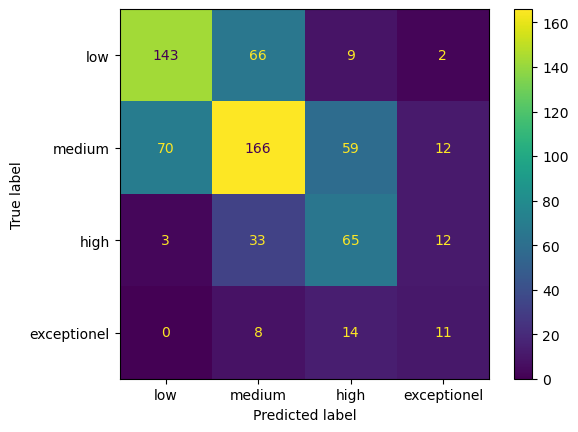

In [1315]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
if target == 'quality_label':
    ConfusionMatrixDisplay(cm, display_labels=categories_in_order).plot()
else:
    ConfusionMatrixDisplay(cm, display_labels=[3,4,5,6,7,8]).plot()

In [1316]:
# classification report
# TODO where do you want to go? what are the requirements?
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.662     0.650     0.656       220
         1.0      0.608     0.541     0.572       307
         2.0      0.442     0.575     0.500       113
         3.0      0.297     0.333     0.314        33

    accuracy                          0.572       673
   macro avg      0.502     0.525     0.511       673
weighted avg      0.583     0.572     0.575       673



In [1259]:
# cohen kappa
cohen_kappa = cohen_kappa_score(y_test, y_pred)
cohen_kappa

np.float64(0.3525239523341914)

How to interpret Cohen Kappa:
- \>= 0.75: good
- 0.40 - 0.60: OK 
- < 0.40: fair, be sceptical
- 0: Random
- <0: worse than random 

## Feature Importances

Compare feature importances to correlations to quality: the ranking should be kind of similar, otherwise the model might rely on noisy data.

alcohol                 0.154445
density                 0.105071
chlorides               0.090529
volatile_acidity        0.090055
total_sulfur_dioxide    0.086709
free_sulfur_dioxide     0.083010
fixed_acidity           0.081538
ph                      0.078519
residual_sugar          0.077695
citric_acid             0.077586
sulphates               0.074842
dtype: float64


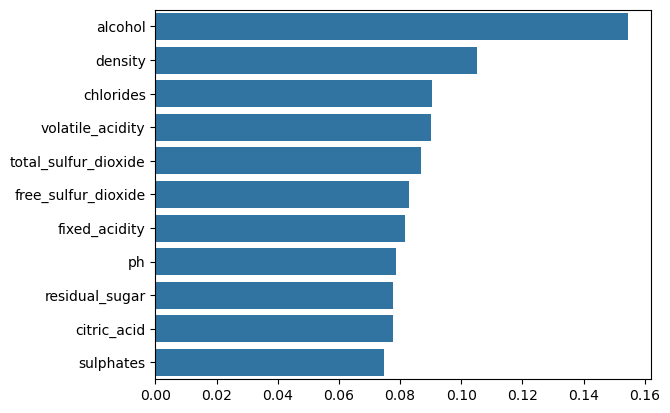

In [1260]:
# feature importances
if hasattr(pipe[-1], 'feature_importances_'):
    feature_importances = pd.Series(pipe[-1].feature_importances_, index=X.columns).sort_values(ascending=False)
    print(feature_importances)
    sns.barplot(feature_importances, orient='h')

### Permutation Feature Importances

- Impact of individual feature permutations on predictions. 
- This method involves randomly shuffling a single feature's values and measuring the resulting performance decrease (e.g., accuracy, F1-score). 

In [1261]:
# Permutation feature importance
result = permutation_importance(pipe, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)
perm_imp_df = pd.DataFrame({
    'Feature': features, 
    'Permutation Importance': result.importances_mean}).sort_values('Permutation Importance', ascending=False)


                 Feature  Permutation Importance
10               alcohol                0.082615
2       volatile_acidity                0.049034
6    free_sulfur_dioxide                0.026895
9                density                0.016642
4              chlorides                0.014710
5   total_sulfur_dioxide                0.012630
7              sulphates                0.010253
1          fixed_acidity                0.007727
8         residual_sugar                0.003566
3            citric_acid                0.002675
0                     ph               -0.002080


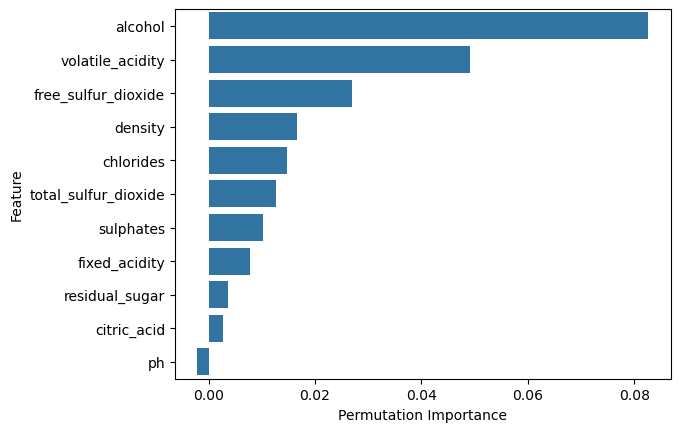

In [1262]:
print(perm_imp_df)
sns.barplot(perm_imp_df, y='Feature', x='Permutation Importance', orient='h');

### Comments on Feature Importances
- As expected from oenologists alcohol is by far the most important feature. It is seen as the carrier for aroma and indicates a complete possibly good fermentation process.
- The following importances do not vary too much, i.e. each feature is almost equally important.
- The model heavily relies on the following features in order:
  - density, which is measure for sweetness and aroma.  
  - volatile acidity as a measure of aging 
  - ph the content of acids
  - total and free sulfur dioxide as a measure of age
  - residual sugar whcih determines the sweetness of wines
  - sulphates which are preservatives
  - chlorides for saltiness
  - fixed acidity
  - citric acid

The permutation on feature importances shows a different and more pronounced order of features than the built-in feature importances: 
- The model heavily relies on Alcohol, Volatile Acidity, Free Sulfur Dioxide;
- It strongly relies on Density, Chlorides, Total Sulfur Dioxide.
- Interestingly Fixed 
- Citric Acid are the least important as well.
- pH is even negative.

The result is closer to the correlation matrix result.

- Volatile Acidity and Free Sulfur Dioxide are more important than shown by the other methods.
Most surprisingly:
- 

### Comparison to Correlation Matrix 
- The model quite different from the correlation matrix.
  - Similarities: The dominant features are alcohol, density, 
  - Differences: 
    - It more strongly relies on Volatile Acidity and Free Sulfur Dioxide, less on Density to predict quality.
- Conclusions / Possibilities
  - Observation underlines non-linear, correlated nature of the problem.
  - Might hint to overfitting: The model pays more attention to the possibly noisy data: free sulfur dioxide and Volatile Acidity.

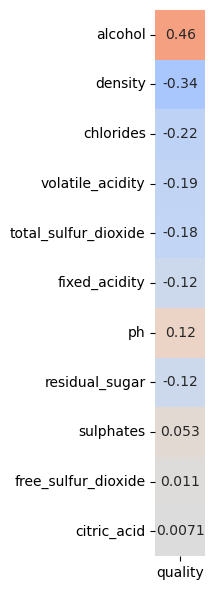

### SHAP Feature Importances

In [1203]:
# # SHAP Explainer
# if  DO_SHAP_EXPLAINER:
#     preprocessor = Pipeline(pipe.steps[:-1])
#     X_train_transformed, y_train_transformed = preprocessor.fit_resample(X_train, y_train)
#     X_test_transformed, y_test_transformed = preprocessor.fit_resample(X_test, y_test)
#     explainer = shap.Explainer(pipe[-1], X_test_transformed) # Transform training data
#     shap_values = explainer(X_test_transformed)

#     # pipeline_predict: is somehow very slow
#     # explainer = shap.Explainer(pipe.predict, X_train)
#     # shap_values = explainer(X_test)

#     # does not exist yet
#     # explainer = shap.PipelineExplainer(pipe, X_train)
#     # shap_values = explainer_pipeline(X_test)

#     # Waterfall plot for the first observation
#     shap.waterfall_plot(shap_values[0])

## Collinearity

In [1263]:
# Calculate VIF for each feature
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

print(vif_data.sort_values('VIF'))

                 Feature          VIF
8         residual_sugar     3.743881
4              chlorides     8.319154
6    free_sulfur_dioxide    11.161226
2       volatile_acidity    12.219372
3            citric_acid    16.709718
7              sulphates    26.363454
5   total_sulfur_dioxide    26.704082
1          fixed_acidity   106.610546
10               alcohol   131.305124
0                     ph   641.289066
9                density  1153.433851


The high VIF numbers indicate that features are strongly related:
- Density has by far the highest VIF, which is not surprising, since all quantities are somehow related to density.
- The same for pH and acids; and alcohol. 

## Condition number

In [1265]:
from numpy.linalg import cond

# Calculate the condition number
condition_number = cond(X_train)
print(f"Condition Number: {condition_number}")

Condition Number: 8899.75045533867


## Cross Validation

In [1266]:
def print_cross_val_scores(scores):
    print("\nCross-validation scores:", scores)
    print("Mean accuracy:", np.mean(scores))
    print("Standard deviation of accuracy:", np.std(scores))
    return None

In [1272]:
# Stratified k fold
if DO_CROSS_VAL:
    sk_folds = StratifiedKFold(n_splits = 10)#, shuffle=False, random_state=RANDOM_STATE)
    f1_weighted = cross_val_score(pipe, X, y, cv=sk_folds, scoring='f1_weighted', n_jobs=-1)
    accuracy = cross_val_score(pipe, X, y, cv=sk_folds, scoring='accuracy', n_jobs=-1)
    print_cross_val_scores(f1_weighted)
    print_cross_val_scores(accuracy)


Cross-validation scores: [0.52423672 0.53729806 0.48991939 0.54345523 0.53220715 0.58297055
 0.50899864 0.50529555 0.56344944 0.51610428]
Mean accuracy: 0.5303935016663537
Standard deviation of accuracy: 0.026545245991932604

Cross-validation scores: [0.52818991 0.54302671 0.48511905 0.54464286 0.5327381  0.57440476
 0.49404762 0.5        0.55952381 0.50595238]
Mean accuracy: 0.5267645188639254
Standard deviation of accuracy: 0.028140359485561664


In [1270]:
# Repeated Random Test-Train Splits
if DO_CROSS_VAL:
    kfold2 = ShuffleSplit(n_splits=10, test_size=0.30, random_state=100)
    scores = cross_val_score(pipe, X, y, cv=kfold2)
    print_cross_val_scores(scores)


Cross-validation scores: [0.56590684 0.55104063 0.53221011 0.53617443 0.54707631 0.52824579
 0.55401388 0.55996036 0.56491576 0.52428147]
Mean accuracy: 0.546382556987116
Standard deviation of accuracy: 0.01453242744481657


* The accuracy from cross validation is lower than the above calculated accuracy. Reasons could be: 
  * class imbalance 
  * overfitting
* The standard deviation is low, indicating that the model is well fitted and might not be overfitted.

# Notes

## Open Questions / Tasks
- Which model to use? Other models that might be useful:
  - random forest
  - gradient boosting tree
  - neural network
- How to tune the model? Hyperparameter Tuning later on
- EDA: What's the connection? Can another feature be thrown out in order to improve the ML result?

## Requirements

### What does the user want?
* A process to simply determine if the produced wine might be high quality or not.
* A simple process could look like this:
  * Measure the basic properties (they might have to measured anyways)
    * residual sugar, ph, density, total sulfur dioxide, fixed and volatile acidity, alcohol
  * If possible, measure the more advanced features: citric acid, chlorides, free sulfur dioxides, sulphates
  * Use the model to infer possible quality rating.
  * Compare the result with the taste of the wine to omit false negative, possibly invite a taster.
  * If good then set the price and marketing strategy appropriately 

### How to setup the model?

1. As many high quality wines predicted correctly.
   1. high f1-score for high quality: wine that is actually high quality should be predicted as high quality
2. Reduce low quality wine creep, i.e. low quality wine predicted as high quality wine.
   1. high f1-score for low quality: 
3. Accuracy as high as possible.

## Results

* Tune Target **Quality Label**
  * With the original quality label definition no high quality wine could be predicted correctly.
  * The high quality wine group is too small!
  * Oversampling and Undersampling further improves the model, see below.
  * Test with more quality levels, in order to emphasize the high quality features:
    * Good result according to confusion matrix, although accuracy is significantly lower.
    * Pros: Exceptional wines can be classified ok manner.
    * Cons: Low precision on exceptional wines.
    * Conlcusion: 
      * not enough high quality data to predict high quality wines
      * stick to 3 labels for now
    * Stack another model on top to differentiate between high and exceptional?
* **Model selection**: compare SVC and RandomForest
  * overall RandomForest yields better results
  * however SVC is great on recall for high quality
  * can the algorithms be combined? yes! stacking
* Which is the appropriate **scaling method**?
  * Compare RobustScaler and MinMaxScaler
  * Result: RobustScaler is slightly better for determining high quality wines
  * What is the influence of the outliers? Removing Outliers before and after
* **Dealing with outliers**
  * Remove all outliers
    * better confusion matrix: Less bad wine is predicted as higher quality; medium wine is more balanced. 
    * lower accuracy score, but better precision, recall, precision. 
  * Remove low quality outliers: Improvement for all scores
    * best result with quality <= 6
    * skew and kurtosis can be reduced with outlier removal.
  * Remove low quality outliers and outliers determined by IsolationForest:
    * best result with quality <= 7: this seems a bit random!
    * improvement of the result!
  * What happens if the high quality outliers are only used for training or testing? 
* **Oversampling and Undersampling**
  * smearing of the confusion matrix
  * leads to slighty lower accuracy, but higher f1 scores for low and high quality
  * major improvement for high quality!
  * With and without outliers? 
  * What about scaling?
* **Feature selection**
  * What is the influence of the other steps on this topic? 
  * **Overall result**: Until now, the best results were achieved when all original features are kept.
    * It seems that all features play a kind of crucial role in this classification problem!
    * Why is this? Although the correlation matrix indicates that collinearity effects might be present, it seems that non-linear effects are more important. This underlines the non-linear, interdependent nature of this problem and calls for machine learning models.
  * Remove features with the lowest impact on quality (citric acid, sulphates, free sulfur dioxide): makes it worse!
  * Remove features which are strongly correlated to each other in order to omit collinearity effects:
    * alcohol, density, residual sugar are strongly correlated
    * remove residual sugar: no improvement
    * remove ph, because it's kind of similar to the acids, it may represent acids that are not yet included; it could simplify model interpretation: no improvement, only a slight difference 
    * remove acids: no improvement
    * remove small values with little spread depending on histogram because the introduce noise, which are sulphates: no improvement 
  * Remove features with high VIF scores: no improvement
  * Remove features by applying PCA: Did not yield a better result, because it's a non-linear problem!
  * Summarize features and replace others
    * sulfur dioxide ratio of free sulfur dioxide or both sulfur dioxide quantities: did not improve the result
    * acid ratio instead: looked promising, but no improvement
    * total acid instead of acids: no improvement; the quantity is mainly driven by Fixed Acid and the features of the other acids are lost 
    * residual sugar * density * alcohol: did not make sense until; proper normalization is necessary
* Use **Quality instead of Quality Label**
  * similar results to modified quality label
  * low quality wines are predicted to be higher quality; high quality wines tend to be rated with lower quality. 
    * Cut off very low quality wines? 
    * What to do about imbalance in data set?
      * Oversamplig does not work here (before it has not really changed the confusion matrix).
      * Use cross validation to check for overfitting effects
* **Cross validation**
  * What is the result of cross validation? What is used for? What does validation exactly mean? Cross validation yields an interesting result: normally the model performs better in cross validation, however, in this case this is not the case.

# Presentation

1. Introduction slide
2. Agenda
3. EDA
4. Machine Learning
   2. Configuration and Tuning: What was done and why? The road to the model
      1. Model: RandomForestClassifier vs SVM (vs ???)
      2. Scaling: RobustScaler vs MinMaxScaler
      3. Imbalanced data: Undersampling, Oversampling
      4. Cross validation: What does the std tell us about the model?
   3. What about the outliers?
      1. I removed the low quality outliers.
      2. Improvement of the model: Accuracy decreased slightly, 
   4. What was achieved? Is the model a good classification machine for the winery?
      1. Resulting confusion matrix
   5. Is the model a good classification machine for the winery?
      1. Up to now high quality wine can be predicted pretty well.
      2. Is more data needed? 